#### From Neurons to Neutrons: A Case Study in Interpretability

In this notebook, we show how you can extract the penultimate layer features shown in the paper.

In [1]:
# Make sure to install the requirements with pip install -r requirements.txt

import glob
import seaborn as sns
import numpy as np
import torch
from src.utils import  IO
from src.data import prepare_nuclear_data
from src.model import get_model_and_optim
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt

sns.set_style('darkgrid')
sns.set_context('paper')

First, we are going to find and load the model:

In [2]:
# extract the subfolders in your models directory
locations = glob.glob('long-runs/models/*')

keys = [l.split('/')[-1].split('-')[1] for l in locations]
def cleanup(name):
    if '+' in name: return 'all'
    while name[-1].isdigit() or name[-1] == '.':
        name = name[:-1]
    return name
keys = [cleanup(k) for k in keys]
locations = {key:l for key, l in zip(keys, locations)}
task_rms_values = {}

In [3]:
# take the model trained on binding energies and load it
model_name = 'binding'
location = locations[model_name]
args = IO.load_args(f"{location}/args.yaml")
args.DEV = "cpu"
data = prepare_nuclear_data(args)
model = get_model_and_optim(data, args)[0]
model.load_state_dict(torch.load(IO.load_latest_model(location), map_location=args.DEV))

mask = data.train_mask & ~torch.isnan(data.y[:, 0])
X_train = data.X[mask]
y_train = data.y[mask]

Loading model from long-runs/models/long_run-binding100-seed0/ckpts/model.pt


Now, we are going to get the penultimate layer activations:

In [4]:
def get_penultimate_acts(model, X):
    # Save the last layer activations
    acts = torch.zeros(len(X), args.HIDDEN_DIM, device=args.DEV)
    # save the activations fed into the readout layer
    hook = model.readout.register_forward_pre_hook(
        lambda m, i: acts.copy_(i[0].detach())
    )
    model(X)
    hook.remove()
    return acts
    

X = data.X
y = data.y
mask = lambda x: x[(X[:, 2] == 0) & ~torch.isnan(y.view(-1))]
X, y = mask(X), mask(y)

acts = get_penultimate_acts(model, X)

Now, we are going to obtain the PC features of the activations:

In [5]:
pca = PCA(n_components=20)
pca.fit(acts.detach().cpu().numpy())
acts_pca = pca.transform(acts.detach().cpu().numpy())

We can now plot them:

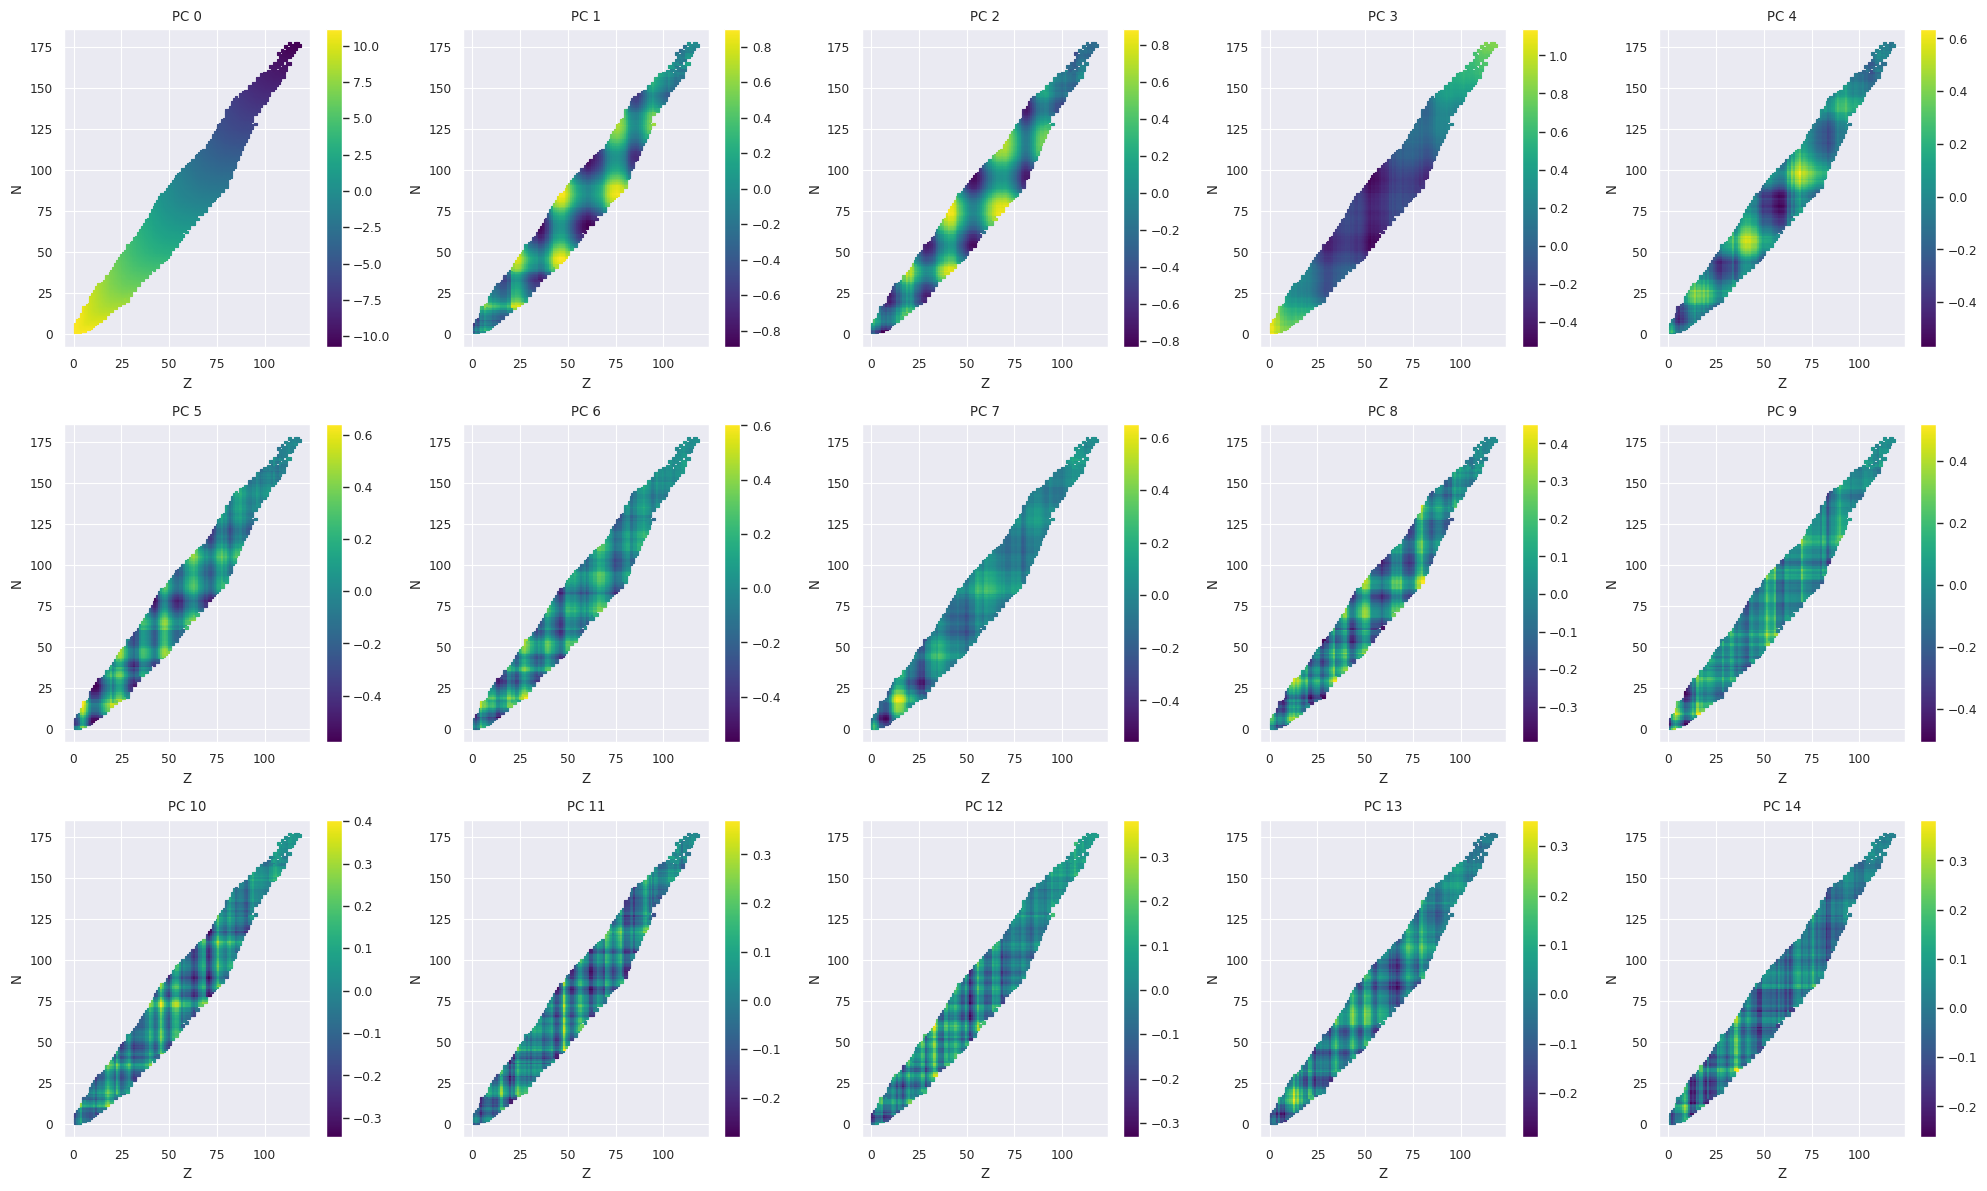

In [6]:
Z, N = X[:, :2].detach().cpu().numpy().T

fig, axes = plt.subplots(3, 5, figsize=(20, 12))
for i in range(len(axes.flatten())):
    ax = axes[i//5, i%5]
    plt.sca(ax)
    plt.scatter(Z, N, c=acts_pca[:, i], cmap="viridis", s=4, marker="s")
    plt.xlabel("Z")
    plt.ylabel("N")
    plt.title(f"PC {i}")
    plt.colorbar()
fig.tight_layout()
plt.show()